# San Diego Burrito Analytics: Data characterization

Scott Cole

23 April 2016

This notebook characterizes the data collected, including:
* How many burritos have been rated?
* How many of each type of burrito have been rated?
* What is the distribution of each of the metrics?

# Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

C:\Users\Scott\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load data

In [2]:
filename="burrito_current.csv"
df = pd.read_csv(filename)
N = df.shape[0]

In [9]:
def loadburritos(filename="burrito_current.csv",
                 cols = ['Location','Burrito','Date','Neighborhood','Hunger',
                        'Cost','Chips','Tortilla','Temp','Meat','Fillings',
                        'Meat:filling','Uniformity','Salsa','Synergy','Wrap',
                         'overall','Reviewer','Rec','Volume']):
    """This function loads data of burrito reivews and organizes it into a dictionary
    """
    # Load data
    import csv
    reader=csv.reader(open(filename,"rb"),delimiter=',')
    csvinput=list(reader)
    
    # Separate headers from data
    headerrow = csvinput[0]
    burritodata = np.array(csvinput[1:])
    Nbur, C = np.shape(burritodata)
    
    # Organize burrito data into a dictionary
    data = {}
    for c in cols:
        data[c] = np.zeros(Nbur,dtype='object')
        colidx = headerrow.index(c)
        for b in range(Nbur):
            data[c][b] = burritodata[b,colidx]
            if not data[c][b]:
                data[c][b] = None
            if np.logical_or(data[c][b] == 'x',data[c][b] == 'X'):
                data[c][b] = 1
            if np.logical_or(data[c][b] == 'yes',data[c][b] == 'Yes'):
                data[c][b] = 1
            if np.logical_or(data[c][b] == 'no',data[c][b] == 'No'):
                data[c][b] = 0
        try:
            data[c] = data[c].astype(float)
        except ValueError:
            print c, 'is not numeric'
    
            
    return data, cols

In [10]:
data, cols = loadburritos()
N = len(data[cols[0]])

Location is not numeric
Burrito is not numeric
Date is not numeric
Neighborhood is not numeric
Reviewer is not numeric


# Describe the data

In [11]:
df

,Location,Burrito,Date,Neighborhood,Address,URL,Hunger,Cost,Chips,Length,...,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.0,6.49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,5.45,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,1.5,4.85,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,2.0,5.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,6.59,x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pollos Maria,combo chicken,1/28/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,6.99,x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nico's Taco Shop,California,1/30/2016,Carmel Valley,3860 Valley Centre Dr #404,http://www.yelp.com/biz/nicos-taco-shop-san-diego,1.5,7.19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Nico's Taco Shop,Carnitas,1/30/2016,Carmel Valley,3860 Valley Centre Dr #404,http://www.yelp.com/biz/nicos-taco-shop-san-diego,4.0,6.99,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Los Primos Mexican Food,Monster California,2/1/2016,UTC,7770 Regents Rd,http://www.primosmex.com/,3.5,9.25,x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,JV's,Carne Asada,2/6/2016,Morena,1112 Morena Blvd,http://jvsmexfood.com/,3.5,6.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print 'Number of burritos:', df.shape[0]
print 'Number of restaurants:', len(df.Location.unique())
print 'Number of reviewers:', len(df.Reviewer.unique())
print 'Number of reviews by Scott:', df.Reviewer.value_counts()['Scott']
print 'Number of reviews by Emily:', df.Reviewer.value_counts()['Emily']

uniqlocidx = df.Location.drop_duplicates().index
print 'Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/len(df.Location.unique()),1)

Number of burritos: 89
Number of restaurants: 31
Number of reviewers: 27
Number of reviews by Scott: 34
Number of reviews by Emily: 19
Percentage of taco shops with free chips: 33


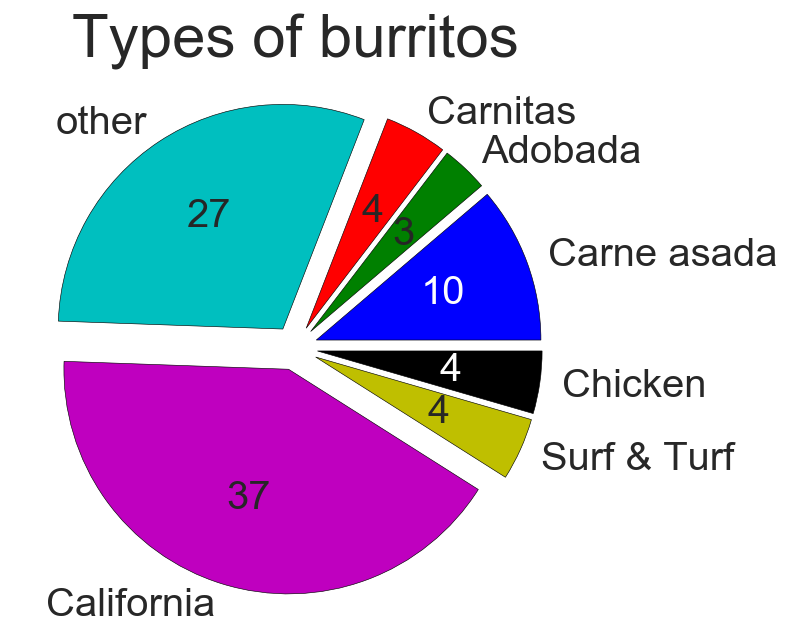

In [29]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = typecounts.values()
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

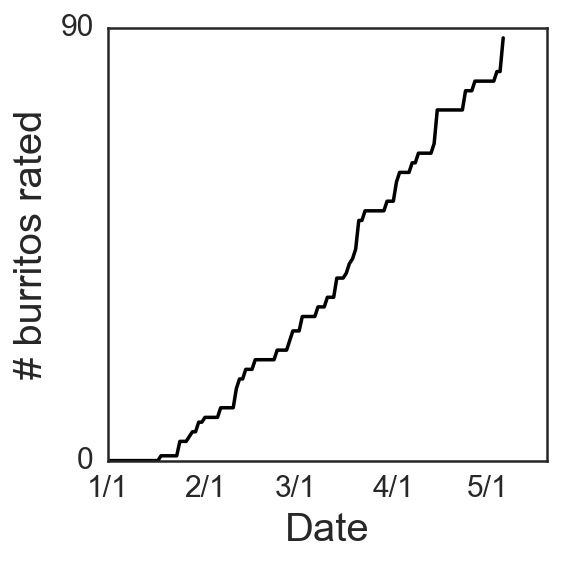

In [31]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(data['Date'][d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 5):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels(M=5)

plt.figure(figsize=(4,4))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date',size=20)
plt.ylabel('# burritos rated',size=20)
plt.xticks(datets,datestrs,size=15)
plt.yticks((0,int(math.ceil(len(burrdays) / 10.0)) * 10),size=15)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

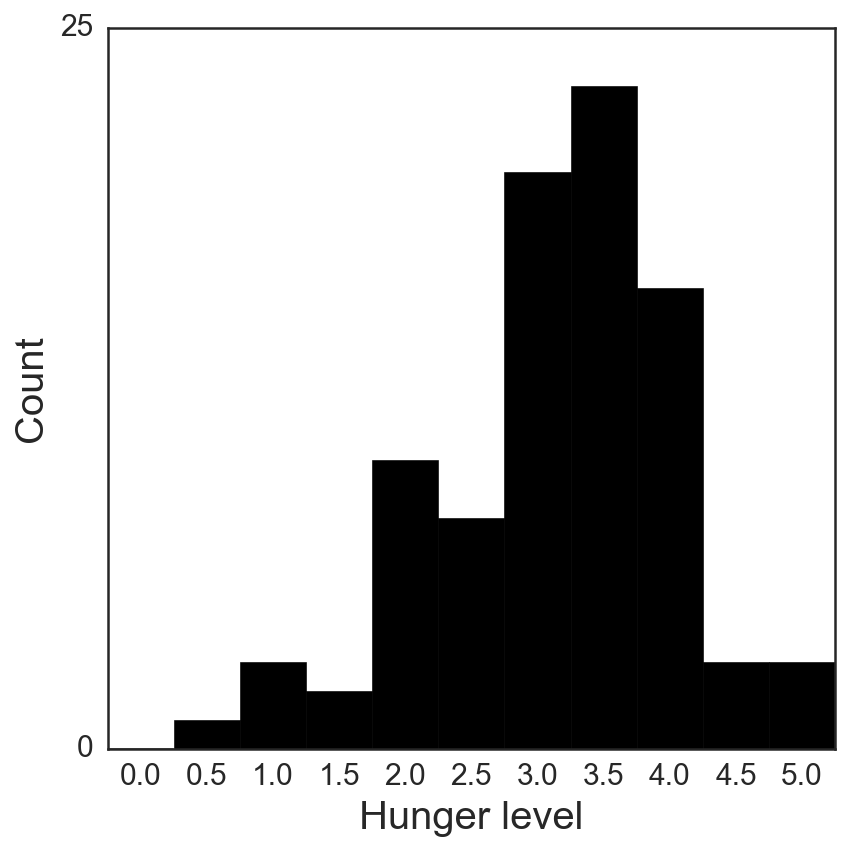

In [32]:
# Distribution of hunger level
plt.figure(figsize=(6,6))
n, _, _ = plt.hist(df.Hunger,np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=15)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

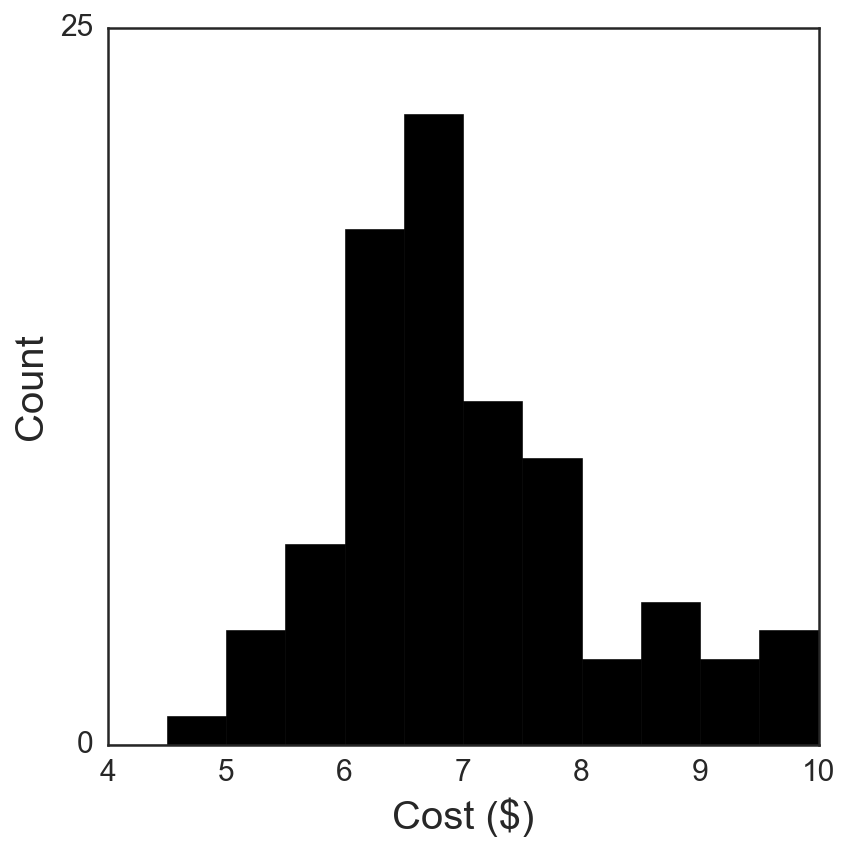

In [34]:
# Average burrito cost
plt.figure(figsize=(6,6))
n, _, _ = plt.hist(df.Cost,np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

In [37]:
def metrichist(metricname):
    plt.figure(figsize=(6,6))
    n, _, _ = plt.hist(df[metricname],np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

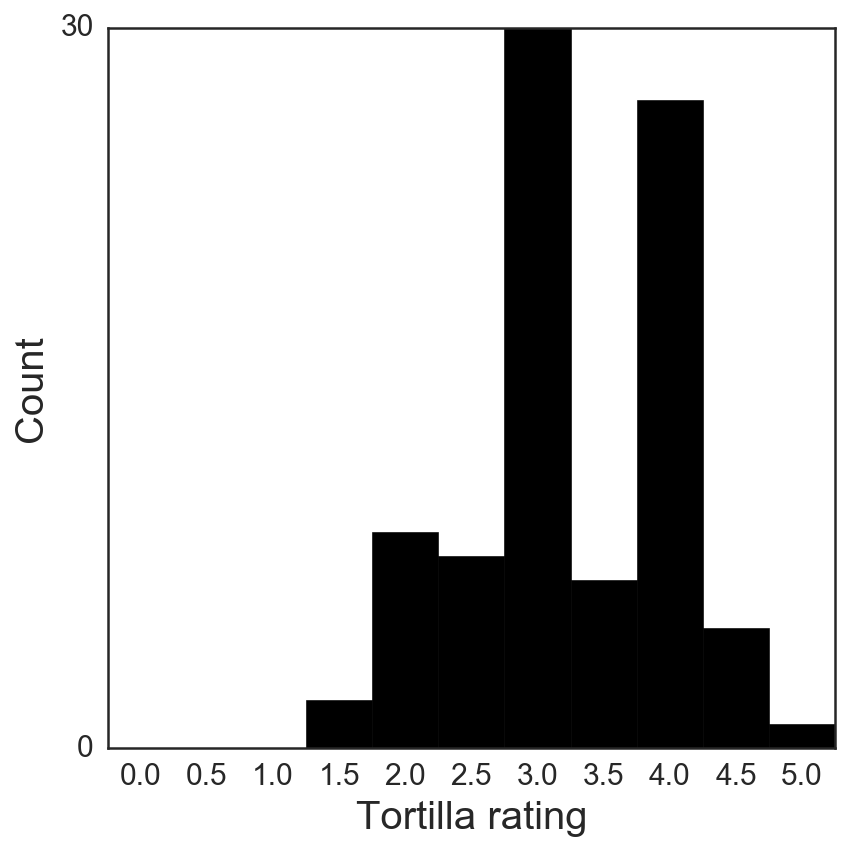

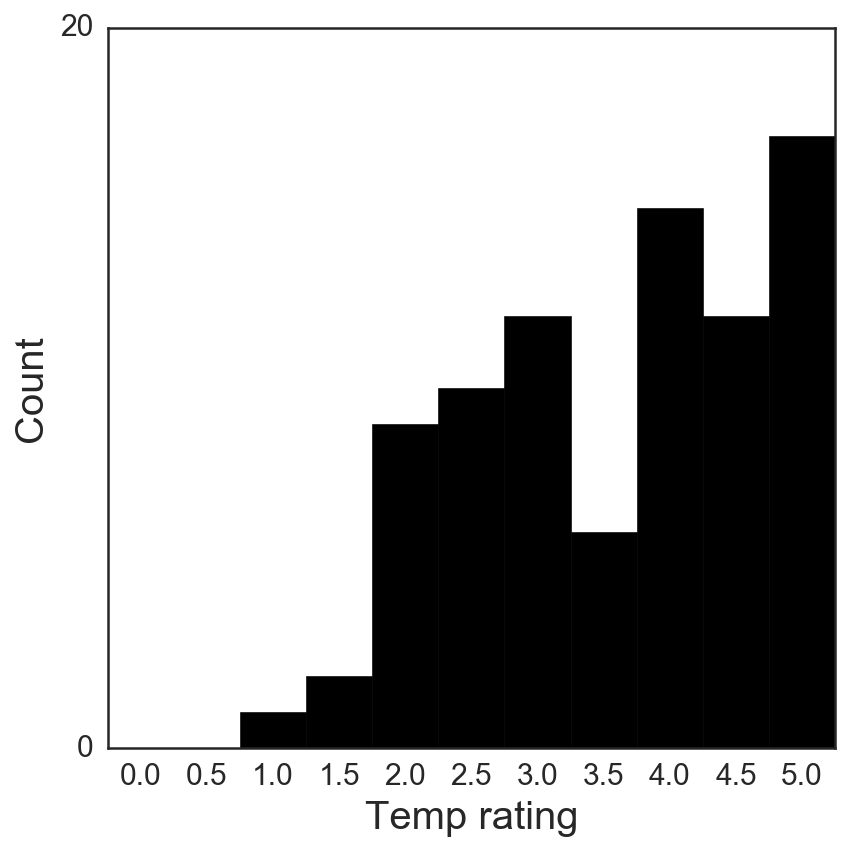

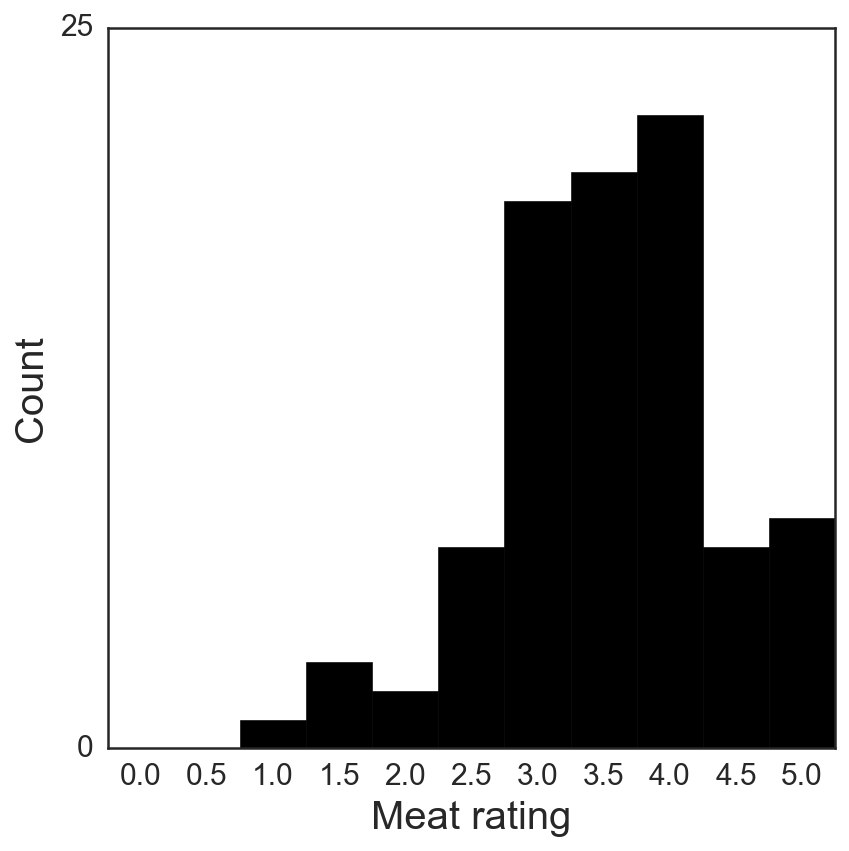

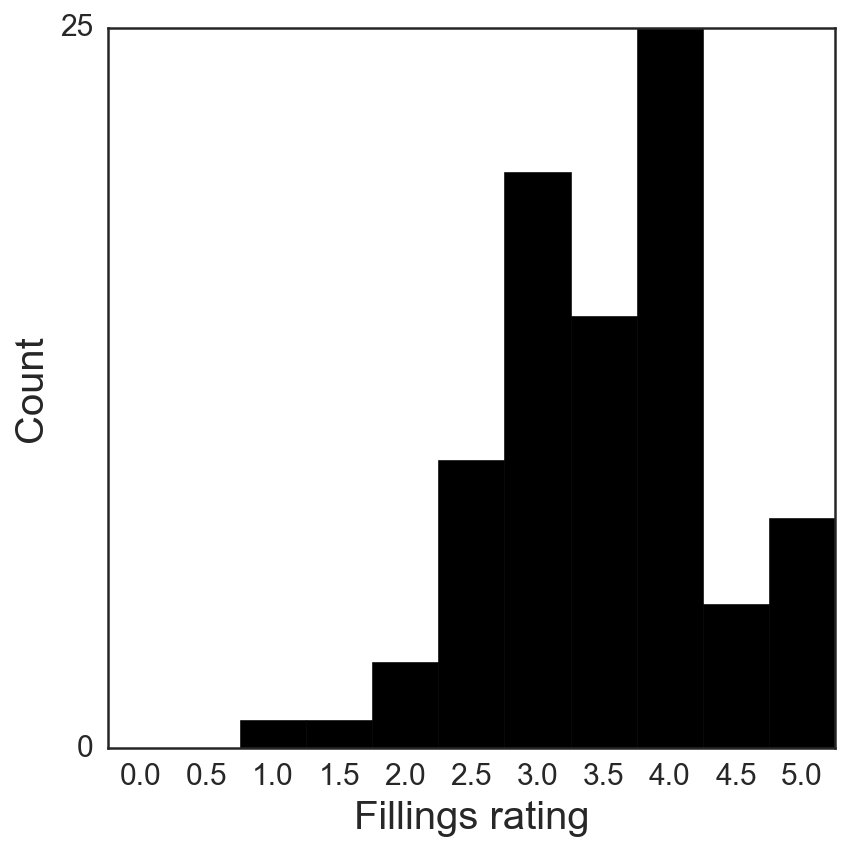

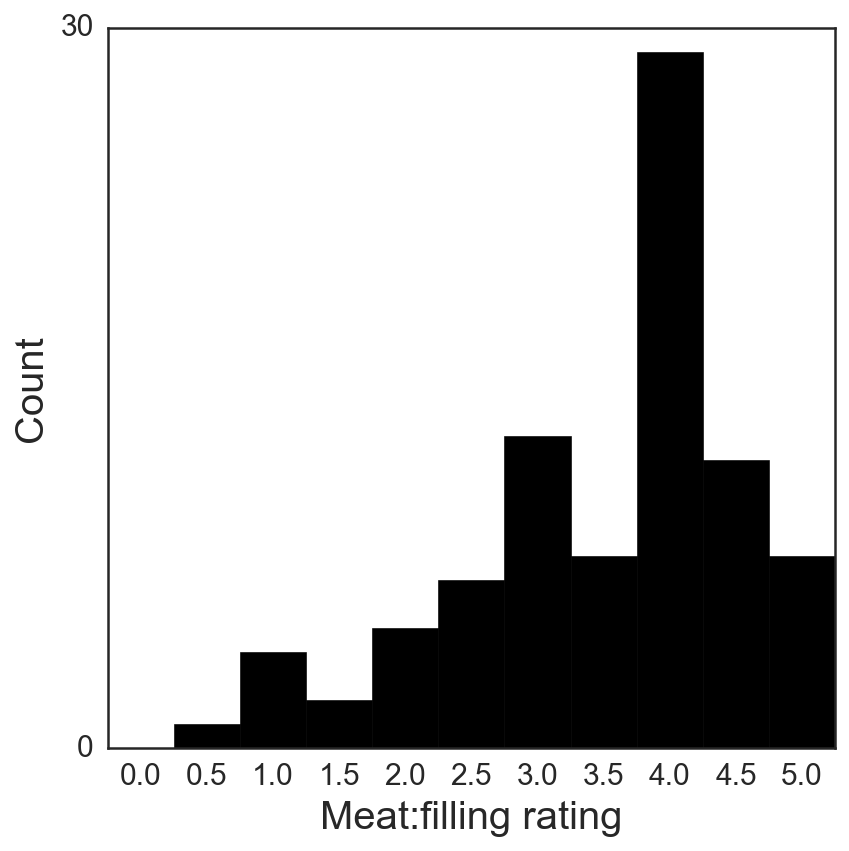

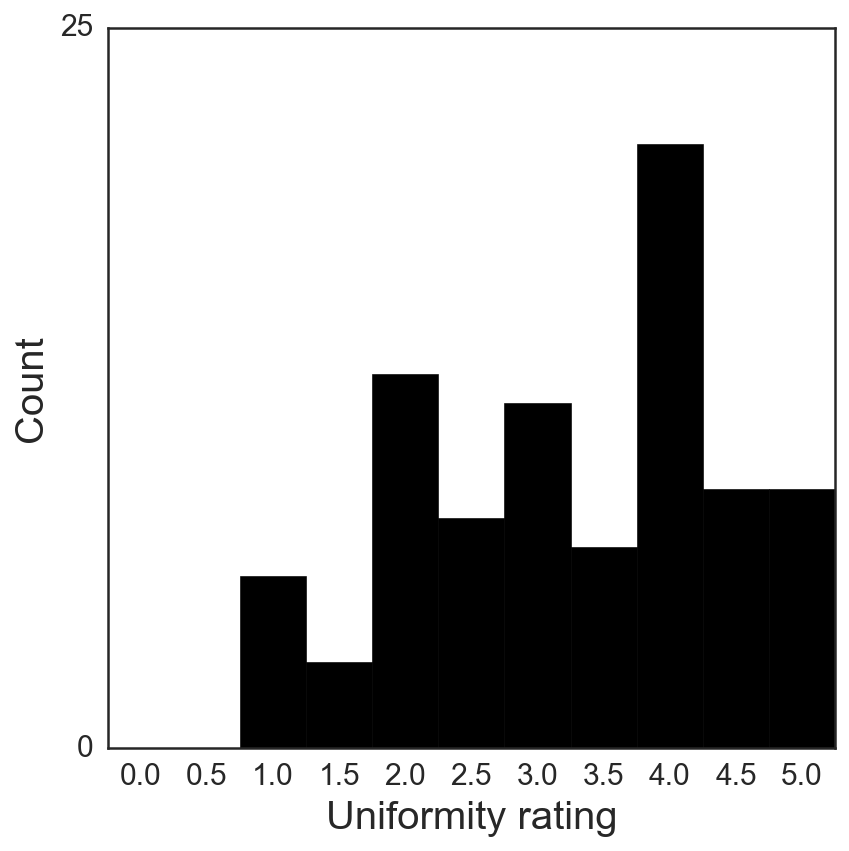

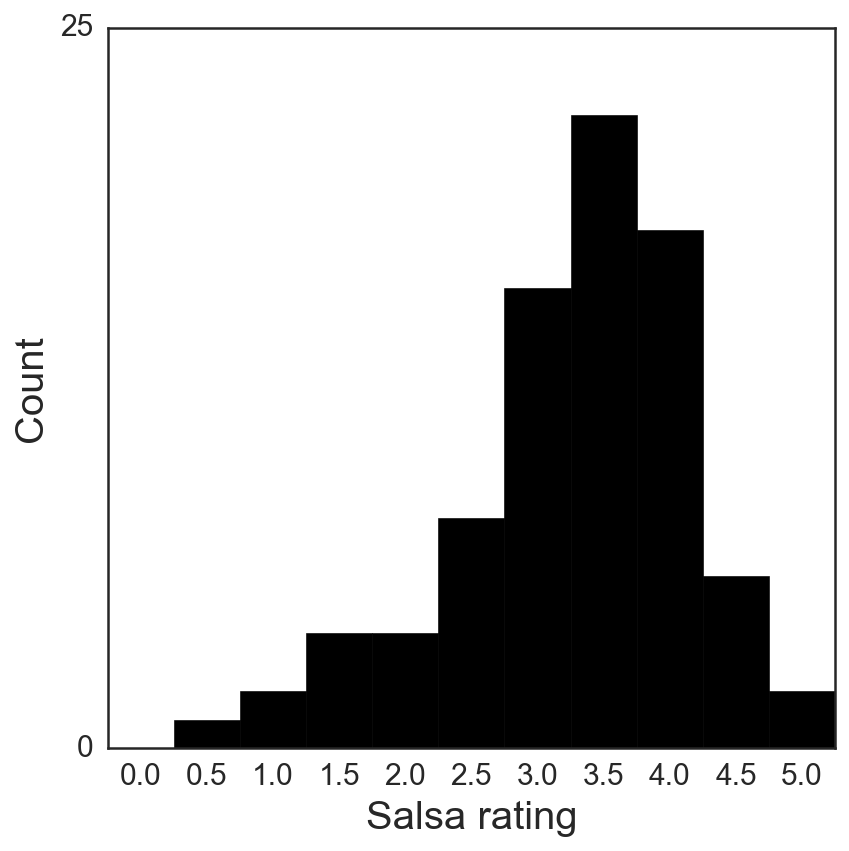

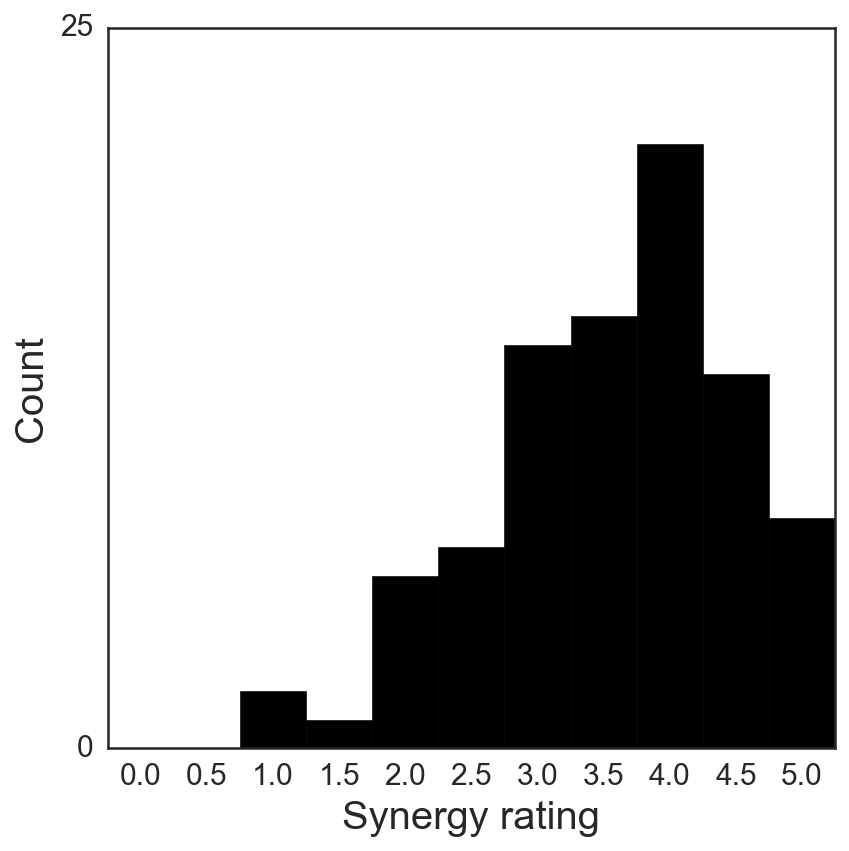

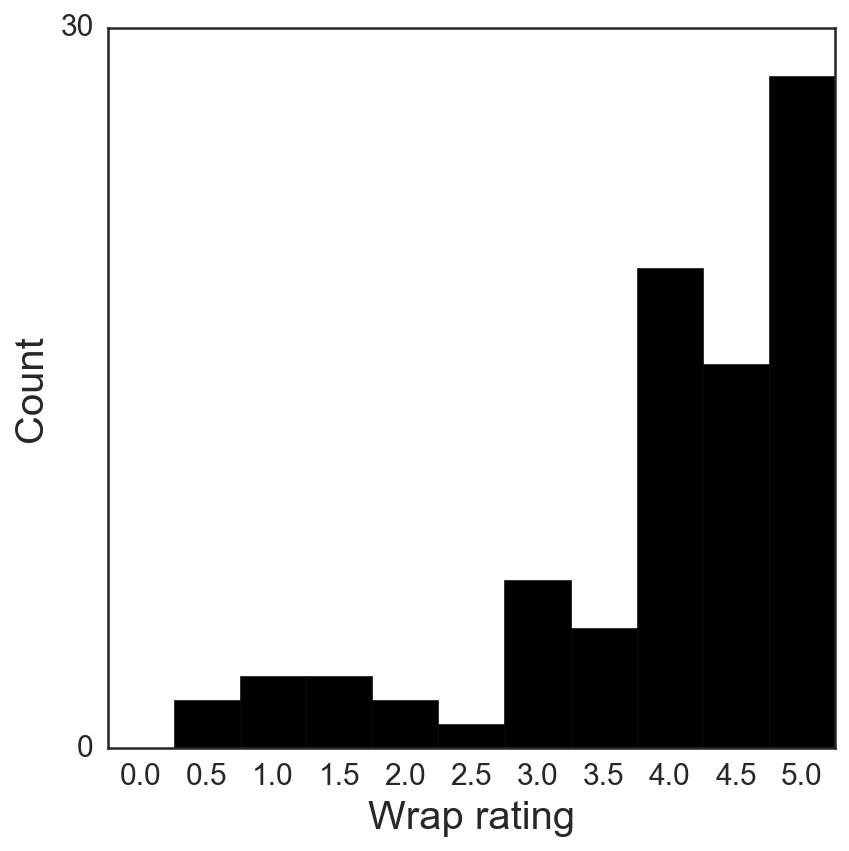

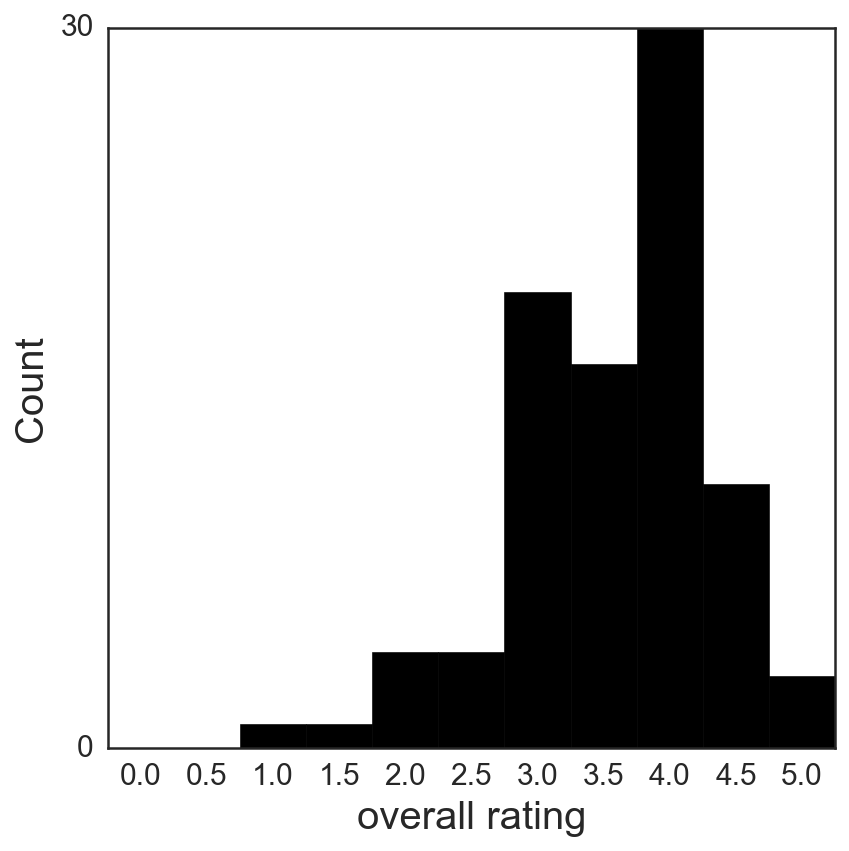

In [38]:
metrics = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in metrics:
    metrichist(m)

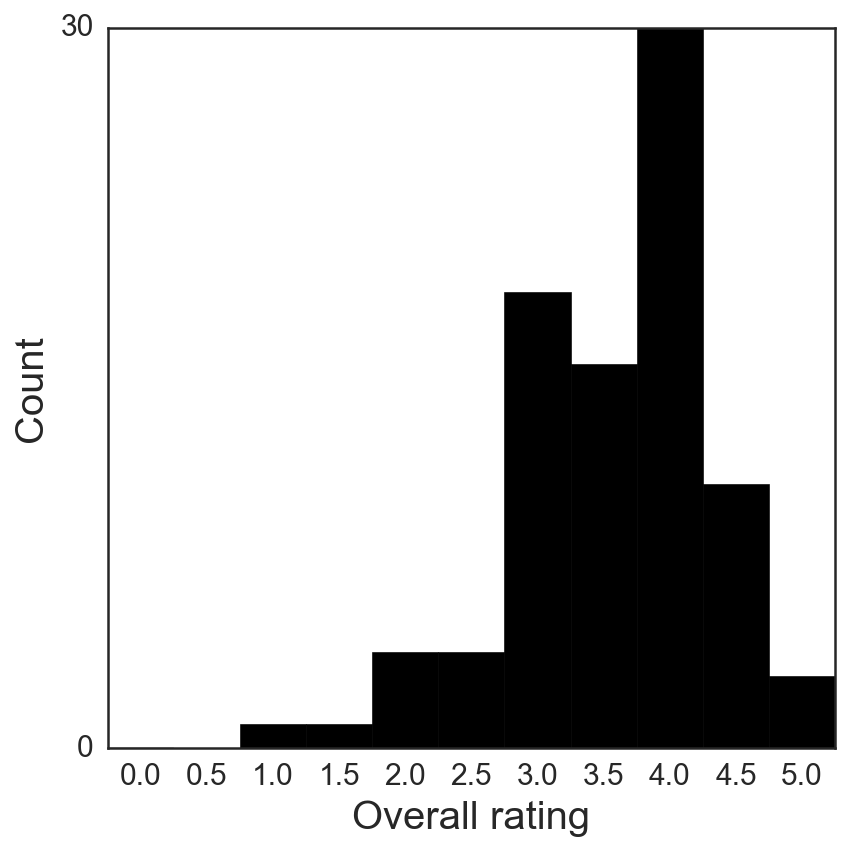

In [42]:
# Distribution of final ratings
plt.figure(figsize=(6,6))
n, _, _ = plt.hist(df.overall,np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Overall rating',size=20)
plt.xticks(np.arange(0,5.5,.5),size=15)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'overalldist'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

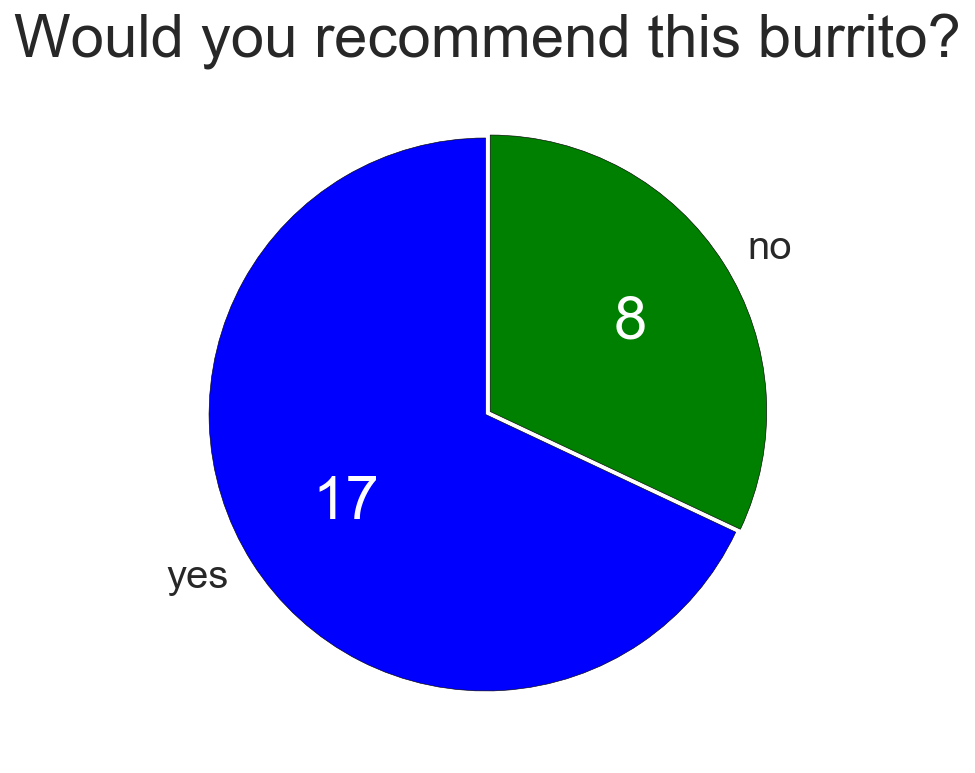

In [45]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')